In [ ]:
This example plots NEXRAD 3 algorithm, precipitation, and derived products (not base data).

In [3]:
import warnings
from awips.dataaccess import DataAccessLayer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest("radar")
available_locs = DataAccessLayer.getAvailableLocationNames(request)
available_locs.sort()
list(available_locs)
request.setLocationNames("kmhx")
availableParms = DataAccessLayer.getAvailableParameters(request)
availableParms.sort()
#list(availableParms)

productIDs = DataAccessLayer.getRadarProductIDs(availableParms)
productNames = DataAccessLayer.getRadarProductNames(availableParms)
print(productIDs)
print(productNames)

['134', '135', '138', '141', '159', '161', '163', '165', '166', '169', '170', '171', '172', '173', '174', '175', '176', '177', '19', '20', '27', '32', '37', '41', '56', '57', '58', '78', '80', '81', '94', '99']
['Composite Refl', 'Correlation Coeff', 'Diff Reflectivity', 'Digital Hybrid Scan Refl', 'Digital Inst Precip Rate', 'Digital Precip Array', 'Digital Vert Integ Liq', 'Echo Tops', 'Enhanced Echo Tops', 'Hybrid Hydrometeor Class', 'Hydrometeor Class', 'Melting Layer', 'Mesocyclone', 'One Hour Accum', 'One Hour Diff', 'One Hour Precip', 'One Hour Unbiased Accum', 'Reflectivity', 'Specific Diff Phase', 'Storm Rel Velocity', 'Storm Total Accum', 'Storm Total Diff', 'Storm Total Precip', 'Storm Track', 'User Select Accum', 'Velocity', 'Vert Integ Liq']



Recs :  1
Time : 2018-10-17 16:37:23
Name : kmhx_0.0_464_464
Prod : Composite Refl
Range: 5.0  to  50.0  (Unit : dBZ )
Size : (464, 464)



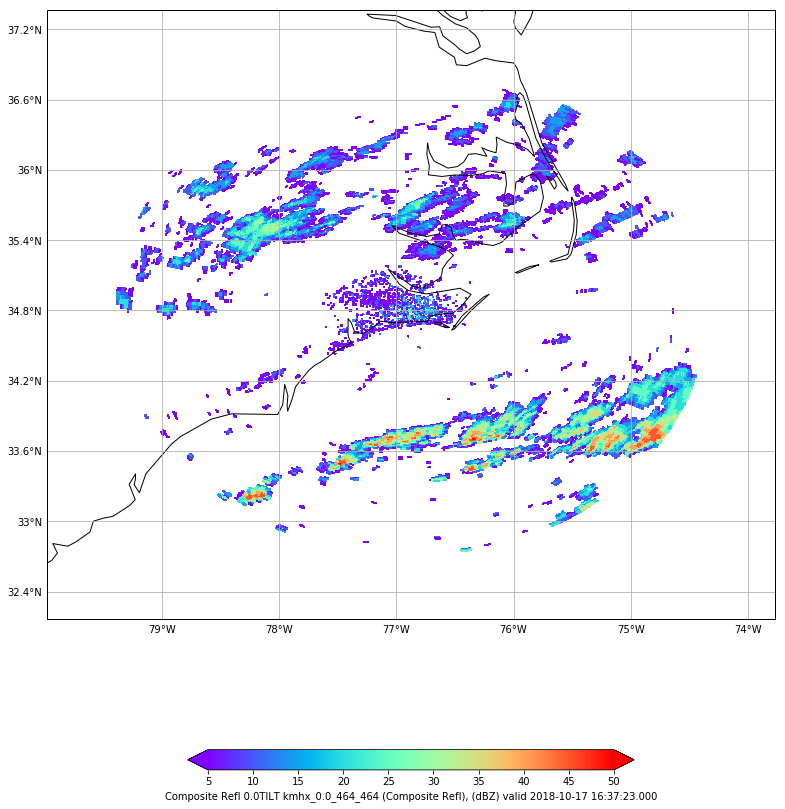

No levels found for Correlation Coeff
No levels found for Diff Reflectivity

Recs :  1
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_230_360_0.0_359.0
Prod : Digital Hybrid Scan Refl
Range: -27.5  to  51.5  (Unit : dBZ )
Size : (230, 360)



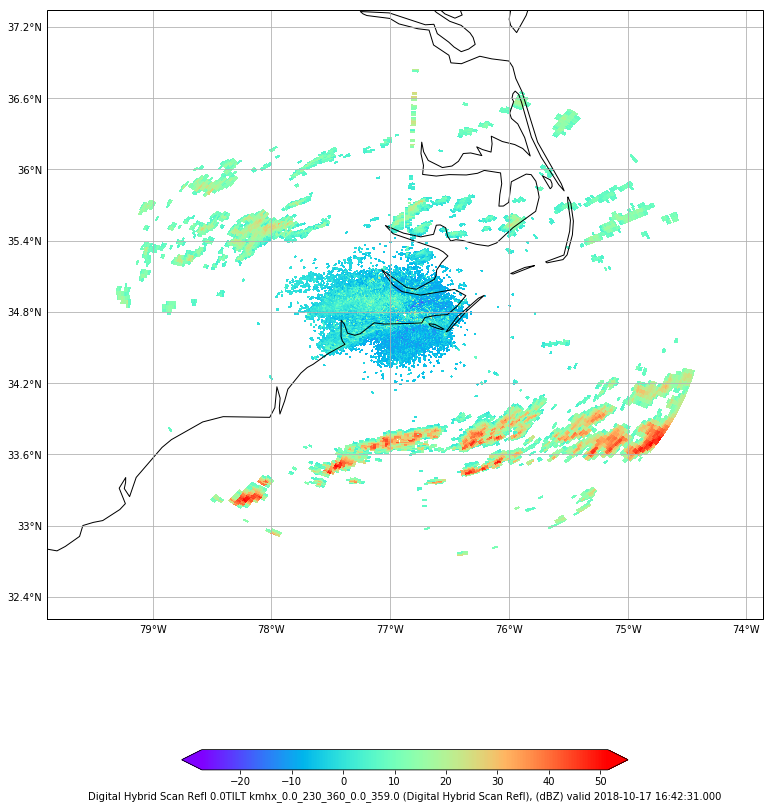


Recs :  1
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_920_360_0.0_359.0
Prod : Digital Inst Precip Rate
Range: 7.0555557e-09  to  2.3071667e-05  (Unit : m*sec^-1 )
Size : (920, 360)



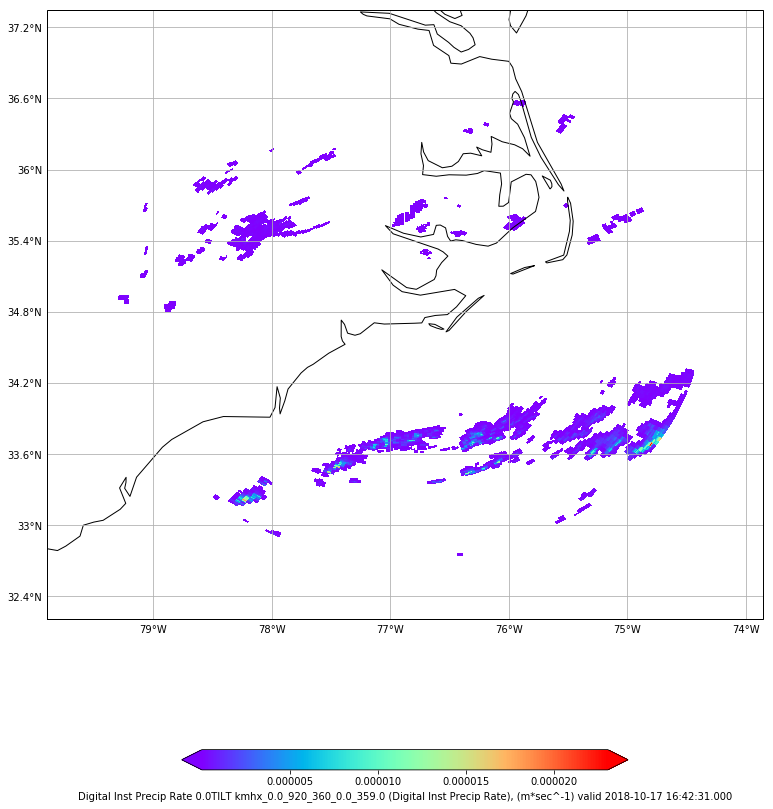


Recs :  1
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_13_13
Prod : Digital Precip Array
Range: 190.0  to  690.0  (Unit : count )
Size : (13, 13)



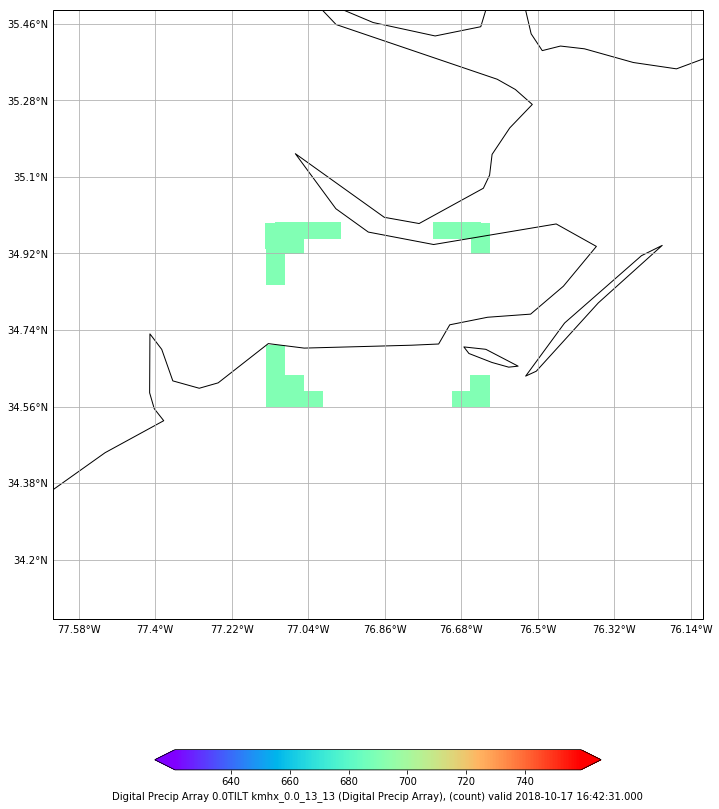


Recs :  1
Time : 2018-10-17 16:37:23
Name : kmhx_0.0_460_360_0.0_359.0
Prod : Digital Vert Integ Liq
Range: 0.0  to  18.834518  (Unit : kg*m^-2 )
Size : (460, 360)



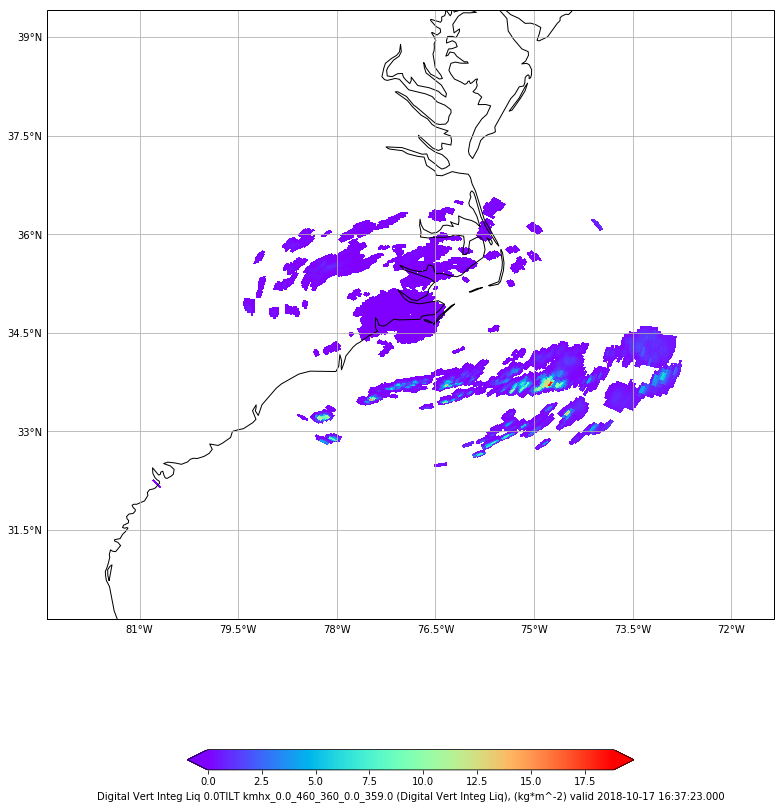


Recs :  1
Time : 2018-10-17 16:37:23
Name : kmhx_0.0_116_116
Prod : Echo Tops
Range: 0.0  to  12192.0  (Unit : m )
Size : (116, 116)



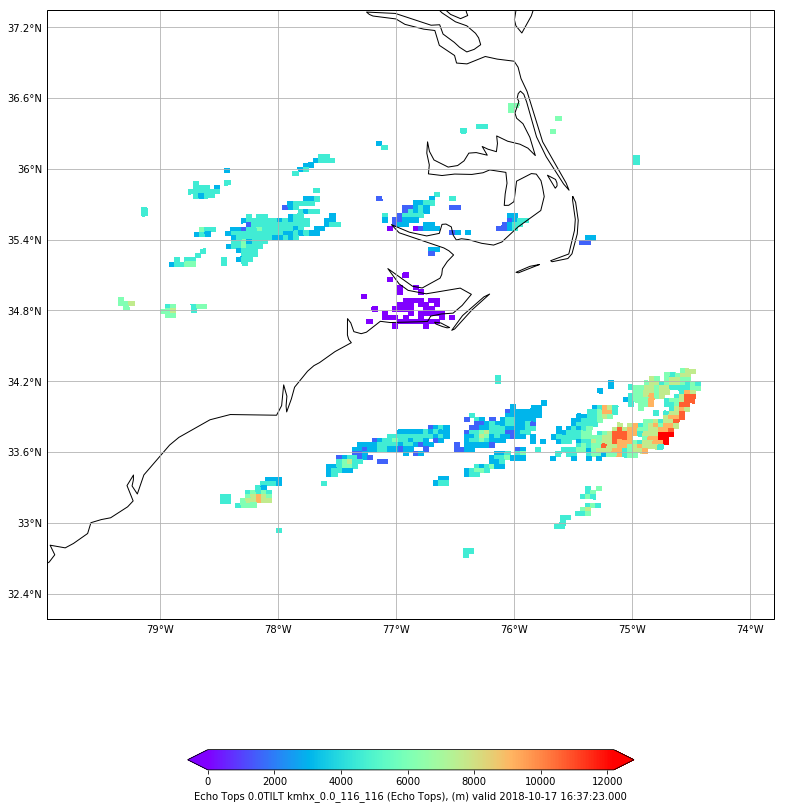


Recs :  1
Time : 2018-10-17 16:37:23
Name : kmhx_0.0_346_360_0.0_359.0
Prod : Enhanced Echo Tops
Range: nan  to  nan  (Unit : m )
Size : (346, 360)



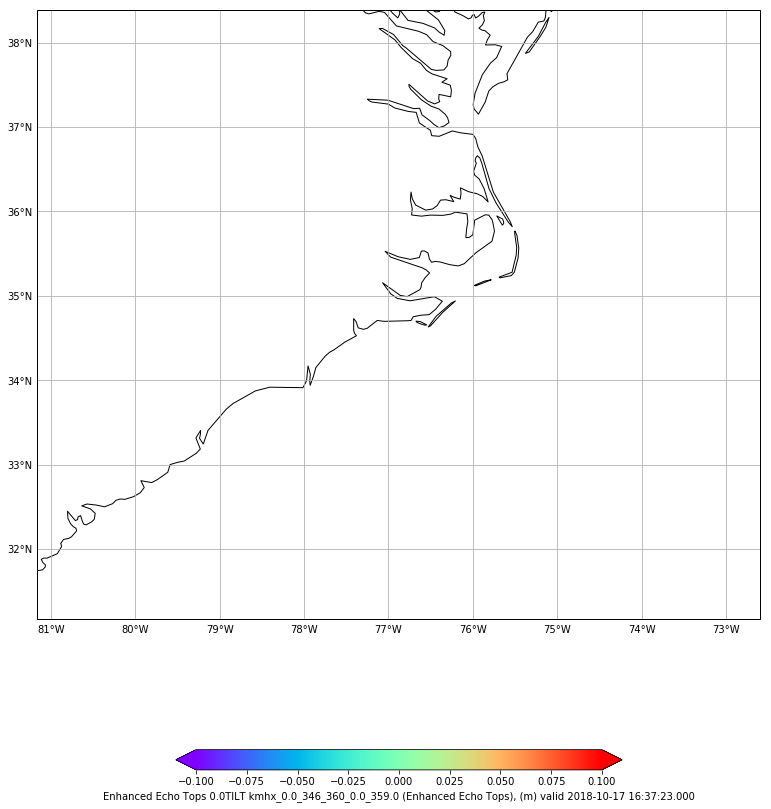


Recs :  1
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_920_360_0.0_359.0
Prod : Hybrid Hydrometeor Class
Range: 1.0  to  14.0  (Unit : count )
Size : (920, 360)



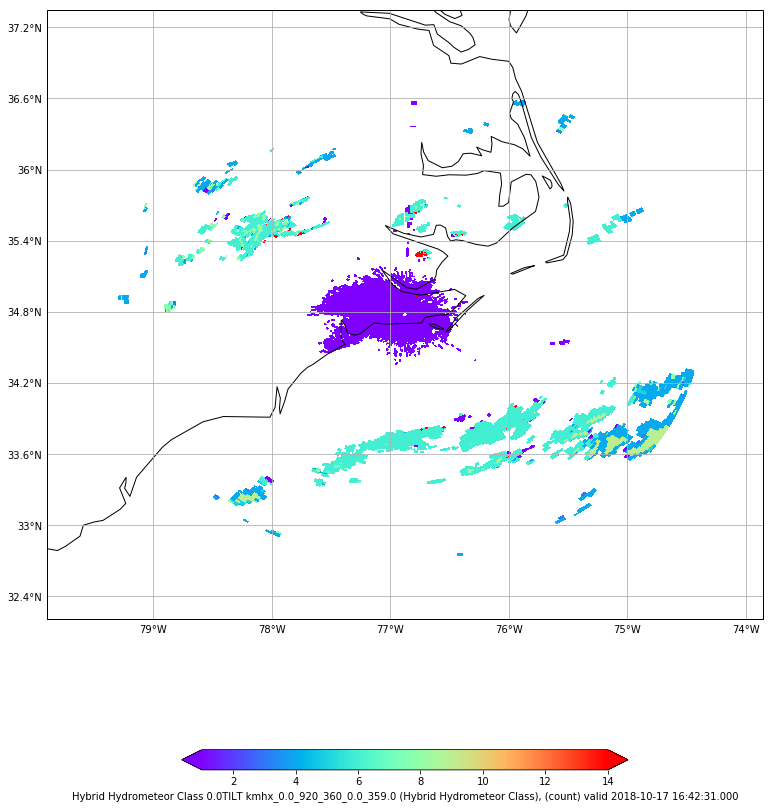

No levels found for Hydrometeor Class
No levels found for Melting Layer

Recs :  0

Recs :  1
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_115_360_359.0_359.0
Prod : One Hour Accum
Range: 0.0  to  0.0127  (Unit : m )
Size : (115, 360)



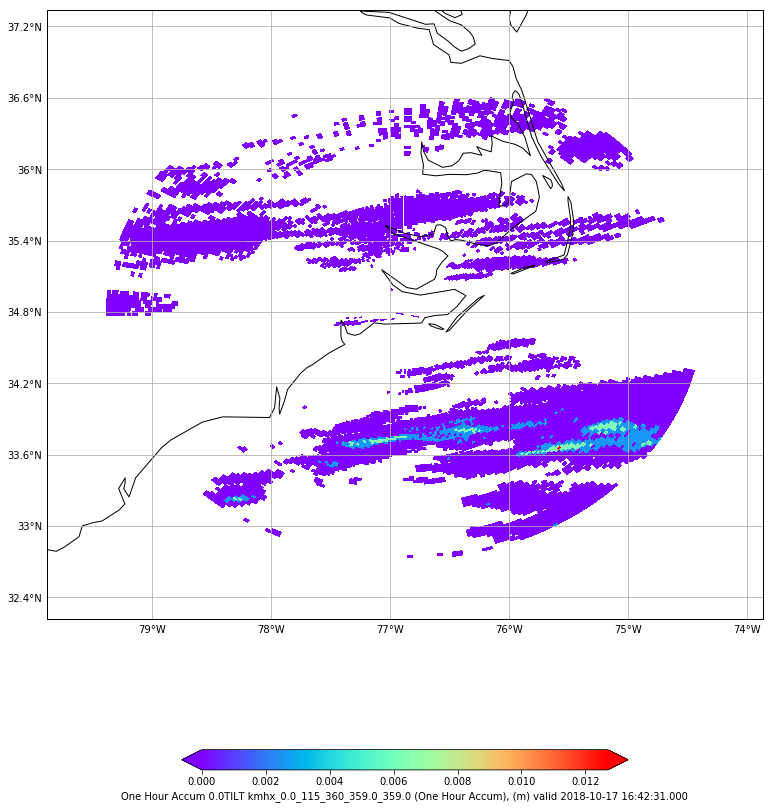


Recs :  1
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_920_360_0.0_359.0
Prod : One Hour Diff
Range: -0.008382  to  0.0027720002  (Unit : m )
Size : (920, 360)



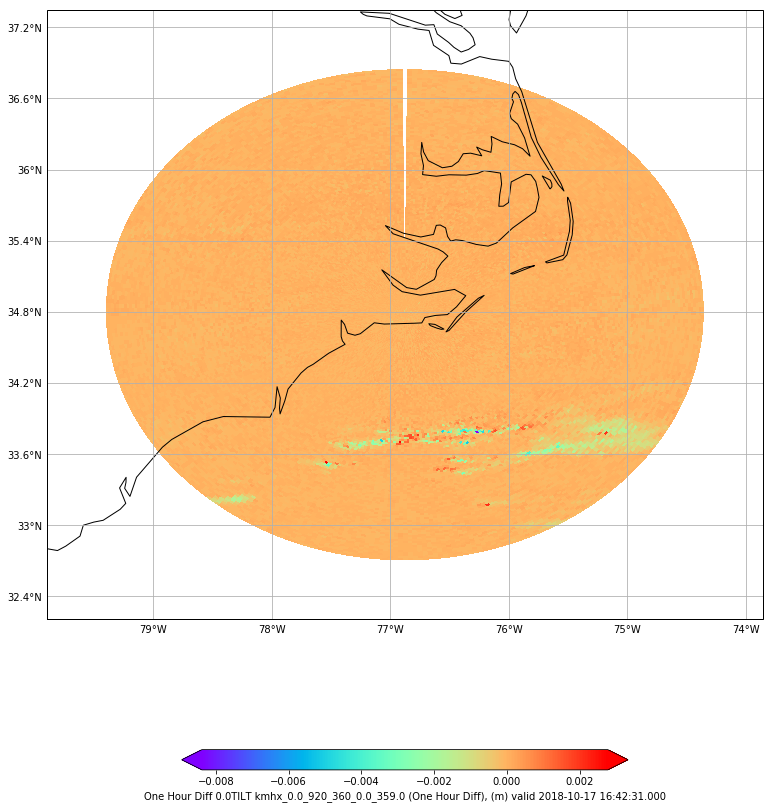


Recs :  1
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_115_360_359.0_359.0
Prod : One Hour Precip
Range: 0.0  to  0.0127  (Unit : m )
Size : (115, 360)



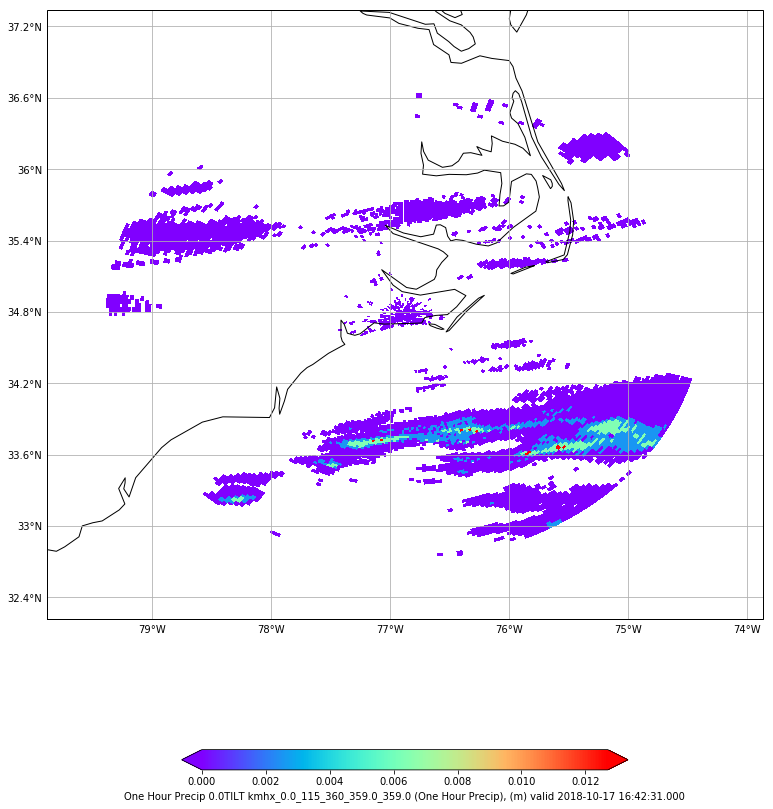


Recs :  1
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_920_360_0.0_359.0
Prod : One Hour Unbiased Accum
Range: 2.5775646e-05  to  0.017472787  (Unit : m )
Size : (920, 360)



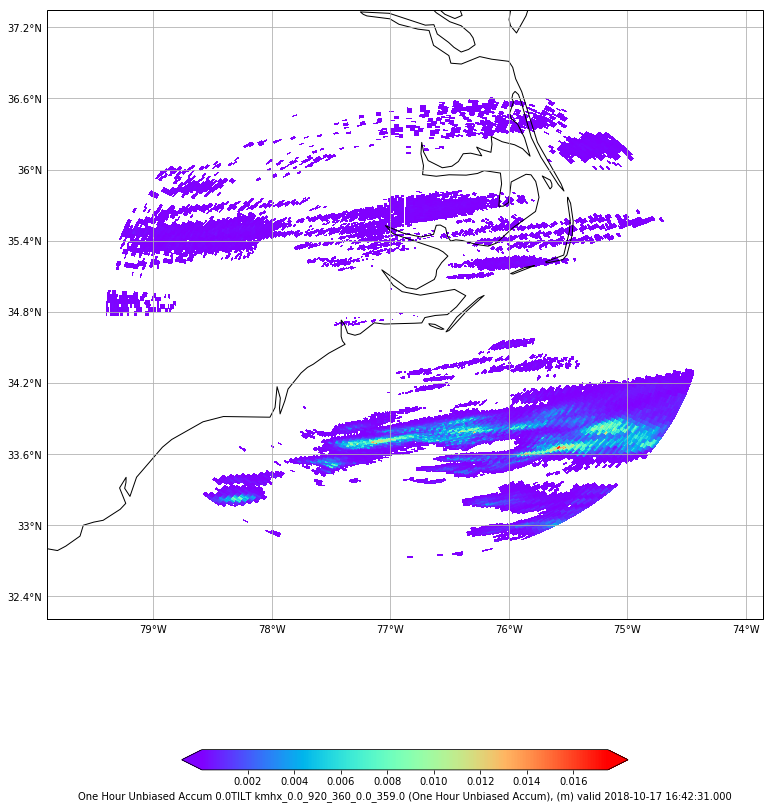

No levels found for Reflectivity
No levels found for Specific Diff Phase
No levels found for Storm Rel Velocity

Recs :  2
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_920_360_0.0_359.0
Prod : Storm Total Accum
Range: 0.000508  to  0.082804  (Unit : m )
Size : (920, 360)



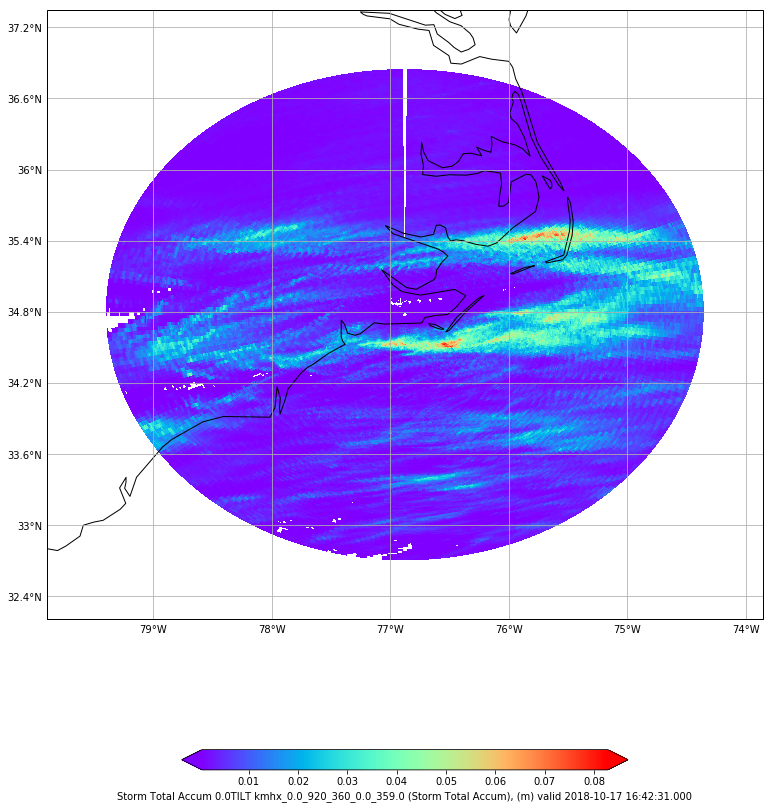


Recs :  1
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_920_360_0.0_359.0
Prod : Storm Total Diff
Range: -0.08255  to  0.019499999  (Unit : m )
Size : (920, 360)



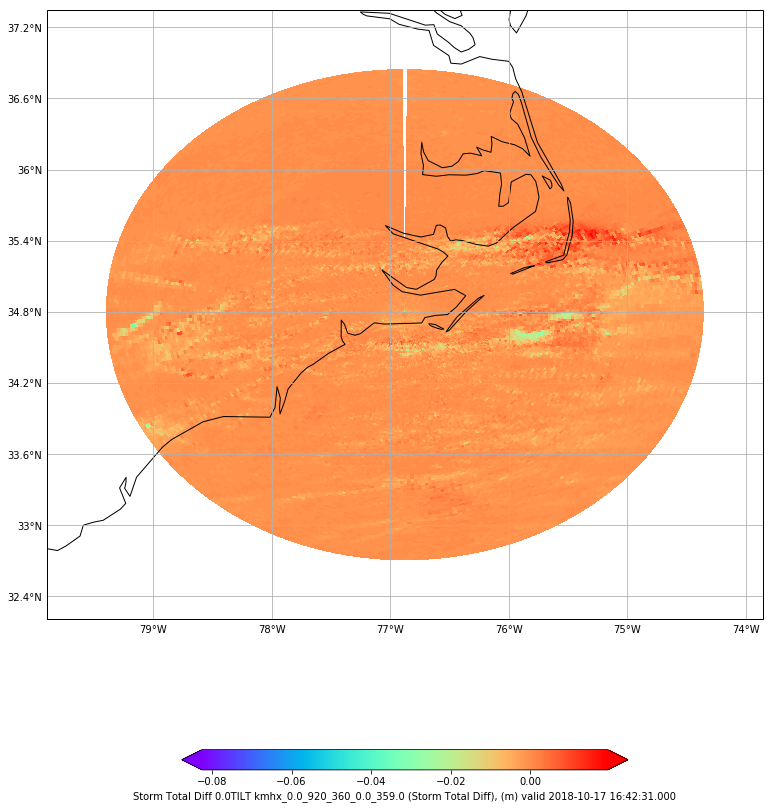


Recs :  2
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_116_360_0.0_359.0
Prod : Storm Total Precip
Range: 0.0  to  0.088392  (Unit : m )
Size : (116, 360)



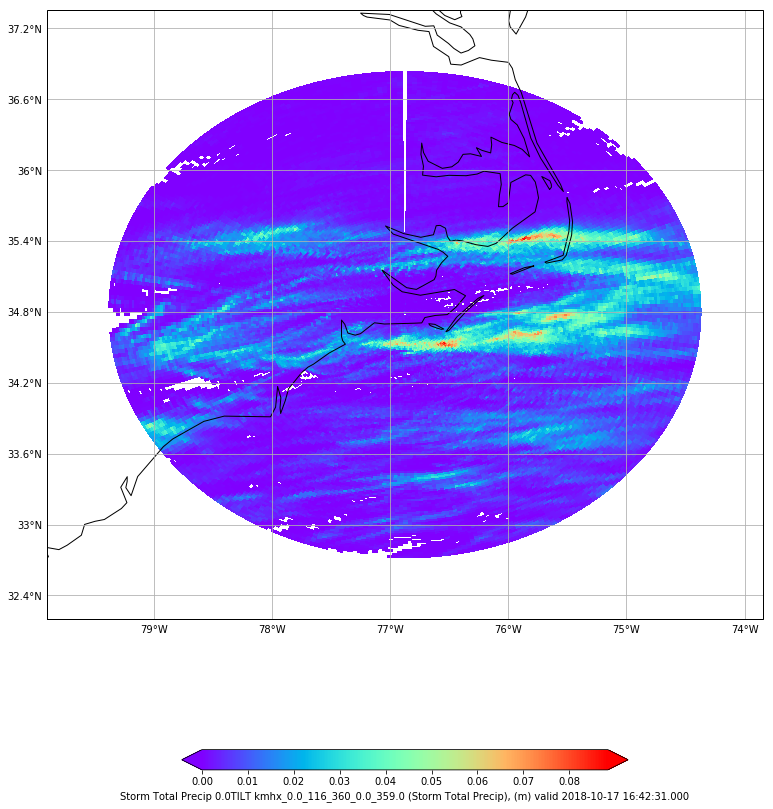


Recs :  0

Recs :  1
Time : 2018-10-17 16:11:08
Name : kmhx_0.0_920_360_0.0_359.0
Prod : User Select Accum
Range: 2.5399999e-05  to  0.033959802  (Unit : m )
Size : (920, 360)



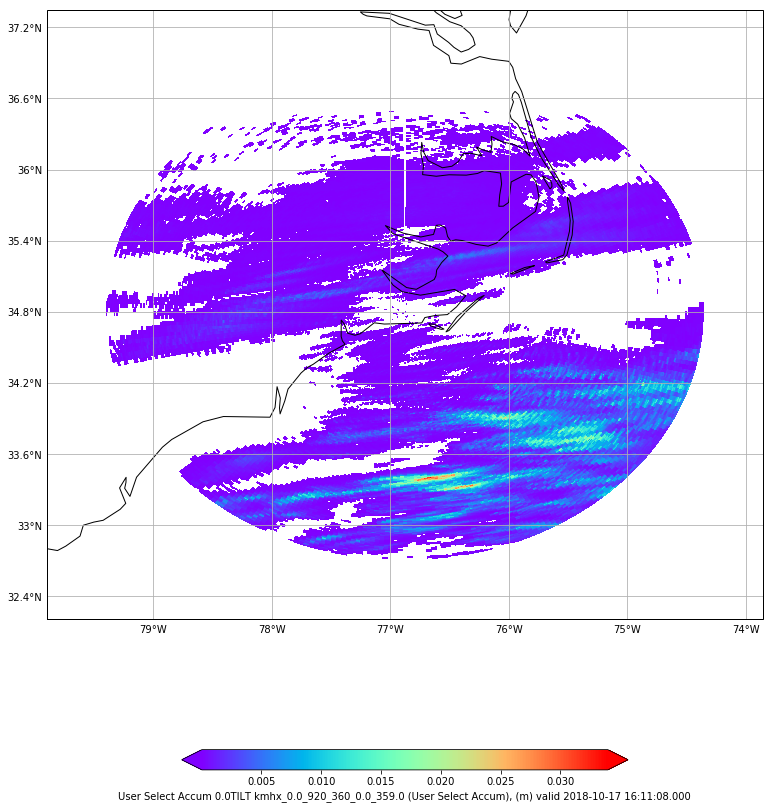

No levels found for Velocity

Recs :  1
Time : 2018-10-17 16:42:31
Name : kmhx_0.0_116_116
Prod : Vert Integ Liq
Range: 1.0  to  20.0  (Unit : kg*m^-2 )
Size : (116, 116)



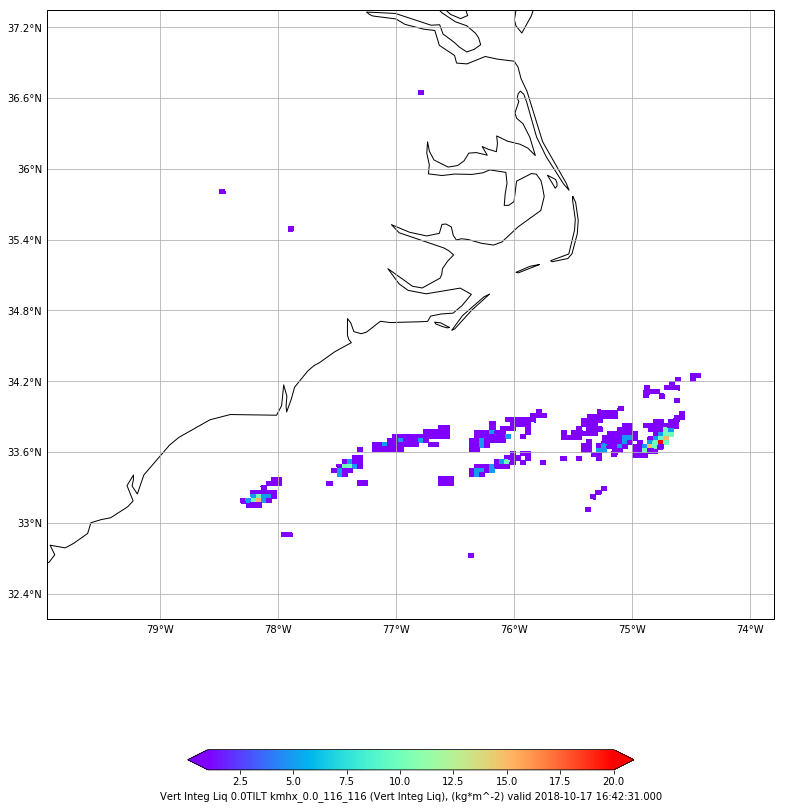

In [4]:
warnings.filterwarnings("ignore",category =RuntimeWarning)

def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 16),
                           subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

nexrad_data = {}

for prod in productNames:
    
    request.setParameters(prod)
    availableLevels = DataAccessLayer.getAvailableLevels(request)
    if availableLevels:
        request.setLevels(availableLevels[0])
    else:
        print("No levels found for " + prod)
        continue

    cycles = DataAccessLayer.getAvailableTimes(request, True)
    times = DataAccessLayer.getAvailableTimes(request)

    if times:
        print()
        response = DataAccessLayer.getGridData(request, [times[-1]])
        print("Recs : ", len(response))
        
        if response:
            grid = response[0]
        else:
            continue
        data = grid.getRawData()
        lons, lats = grid.getLatLonCoords()

        nexrad_data[prod] = data
        
        print('Time :', str(grid.getDataTime()))
        flat = np.ndarray.flatten(data)
        print('Name :', str(grid.getLocationName()))
        print('Prod :', str(grid.getParameter()))
        print('Range:' , np.nanmin(flat), " to ", np.nanmax(flat), " (Unit :", grid.getUnit(), ")")
        print('Size :', str(data.shape))
        print()

        cmap = plt.get_cmap('rainbow')
        bbox = [lons.min()-0.5, lons.max()+0.5, lats.min()-0.5, lats.max()+0.5]
        fig, ax = make_map(bbox=bbox)
        cs = ax.pcolormesh(lons, lats, data, cmap=cmap)
        cbar = fig.colorbar(cs, extend='both', shrink=0.5, orientation='horizontal')
        cbar.set_label(grid.getParameter() +" " + grid.getLevel() + " " \
                       + grid.getLocationName() + " (" + prod + "), (" + grid.getUnit() + ") " \
                       + "valid " + str(grid.getDataTime().getRefTime()))
        plt.show()